# Using TensorFlow with own data
- notebook focusing on formatting and feeding raw data into a neural network
- download pos and neg word docs, which will need to be converted to a vector of features
- Steps:
 1. Use simple bag-of-words model to create unique word list and label training vector based on indices of unique word vector

In [34]:
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
import random
import pickle
from collections import Counter
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
import matplotlib.pyplot as plt
from functions.random_mini_batches import random_mini_batches

In [2]:
import os
os.getcwd()

'/Users/thor/Python/Projects/Tensorflow'

In [3]:
lemmatizer = WordNetLemmatizer()
hm_lines = 100000

pos = 'data/pos.txt'
neg = 'data/neg.txt'

In [4]:
def create_lexicon(pos,neg):

# Open the text files, tokenize the words, and add them to the lexicon

    lexicon=[]
    with open(pos, 'r') as f:
        contents = f.readlines()
        for l in contents[:hm_lines]:
            all_words = word_tokenize(l)
            lexicon += list(all_words)
        
    with open(neg, 'r') as f:
        contents = f.readlines()
        for l in contents[:hm_lines]:
            all_words = word_tokenize(l)
            lexicon += list(all_words)
            
# need to lemmatize the words to remove duplicates and common words

    lexicon = [lemmatizer.lemmatize(word) for word in lexicon]
    w_counts = Counter(lexicon)
    l2 = []
    for w in w_counts:
        if 1000 > w_counts[w] > 50:
            l2.append(w)
    return l2

In [5]:
def sample_handling(sample,lexicon,classification):
    
    featureset=[]
    
    with open(sample, 'r') as f:
        contents = f.readlines()
        for l in contents[:hm_lines]:
            current_words = word_tokenize(l.lower())
            current_words = [lemmatizer.lemmatize(word) for word in current_words]
            features = np.zeros(len(lexicon))
            for word in current_words:
                if word.lower() in lexicon:
                    index_value = lexicon.index(word.lower())
                    features[index_value] += 1
                    
            features = list(features)
            featureset.append([features,classification])
            
    return featureset

In [6]:
def create_feature_sets_and_labels(pos,neg,test_size = 0.1):
    lexicon = create_lexicon(pos,neg)
    print(len(lexicon))
    features = []
    features += sample_handling('data/pos.txt', lexicon, [1,0])
    features += sample_handling('data/neg.txt', lexicon, [0,1])
    random.shuffle(features)
    features = np.array(features)
    print(features.shape)
    
    testing_size = int(test_size*len(features))
    
    x_train = list(features[:,0][:-testing_size])
    y_train = list(features[:,1][:-testing_size])
    x_test = list(features[:,0][-testing_size:])
    y_test = list(features[:,1][-testing_size:])
    
    return x_train, y_train, x_test, y_test, features

In [7]:
if __name__ == '__main__':
    x_train, y_train, x_test, y_test, features = create_feature_sets_and_labels(pos,neg)
#with open('data/final_data.pickle','wb') as f:
   # pickle.dump([x_train,y_train,x_test,y_test],f)

423
(10662, 2)


In [8]:
X_train = np.asanyarray(x_train,dtype=np.float32)
X_test = np.asanyarray(x_test, dtype=np.float32)
y_train = np.asanyarray(y_train, dtype=np.float32)
y_test = np.asanyarray(y_test, dtype=np.float32)

print('Shape is (n_features,n_samples)')
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_train shape: {X_test.shape}')
print(f'y_train shape: {y_test.shape}')

Shape is (n_features,n_samples)
X_train shape: (9596, 423)
y_train shape: (9596, 2)
X_train shape: (1066, 423)
y_train shape: (1066, 2)


In [60]:
# Create and build model
tf.reset_default_graph()
# Define hidden layers and how many nodes
n_nodes_hl1 = 1500
n_nodes_hl2 = 1500
n_nodes_hl3 = 1500

# Define number of classes
n_classes = 2

x = tf.placeholder('float')
y = tf.placeholder('float')

hidden_1_layer = {'f_fum':n_nodes_hl1,
                  'weight':tf.get_variable("W1", [X_train.shape[1], n_nodes_hl1], initializer = tf.contrib.layers.xavier_initializer(seed = 1)),
                  'bias':tf.get_variable("b1", [n_nodes_hl1], initializer = tf.zeros_initializer())}

hidden_2_layer = {'f_fum':n_nodes_hl2,
                  'weight':tf.get_variable("W2",[n_nodes_hl1, n_nodes_hl2], initializer = tf.contrib.layers.xavier_initializer(seed = 1)),
                  'bias':tf.get_variable("b2", [n_nodes_hl2], initializer = tf.zeros_initializer())}

hidden_3_layer = {'f_fum':n_nodes_hl3,
                  'weight':tf.get_variable("W3", [n_nodes_hl2, n_nodes_hl3], initializer = tf.contrib.layers.xavier_initializer(seed = 1)),
                  'bias':tf.get_variable("b3", [n_nodes_hl3], initializer = tf.zeros_initializer())}

output_layer = {'f_fum':None,
                'weight':tf.get_variable("out_w",[n_nodes_hl3, n_classes], initializer = tf.contrib.layers.xavier_initializer(seed = 1)),
                'bias':tf.get_variable("out_b", [n_classes], initializer = tf.zeros_initializer())}


# Nothing changes
def neural_network_model(x):

    l1 = tf.add(tf.matmul(x,hidden_1_layer['weight']), hidden_1_layer['bias'])
    l1 = tf.nn.relu(l1)

    l2 = tf.add(tf.matmul(l1,hidden_2_layer['weight']), hidden_2_layer['bias'])
    l2 = tf.nn.relu(l2)

    l3 = tf.add(tf.matmul(l2,hidden_3_layer['weight']), hidden_3_layer['bias'])
    l3 = tf.nn.relu(l3)

    output = tf.matmul(l3,output_layer['weight']) + output_layer['bias']

    return output

# Create function to train the neural net
def train_neural_network(X_train, y_train, X_test, y_test, epochs = 10, batch_size=64):
    costs=[]
    
    # Resert graph
    #tf.reset_default_graph()
    
    #Training the network
    prediction = neural_network_model(x)
    
    # Define the cost
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = prediction, labels = y))
    
    # Define the optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

    # Run the session
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        
        for epoch in range(epochs):
            epoch_loss = 0
            i=0
            while i < len(X_train):
                start = i
                end = i+batch_size
                batch_x = np.array(X_train[start:end])
                batch_y = np.array(y_train[start:end])

                _, c = sess.run([optimizer, cost], feed_dict={x: batch_x, y: batch_y})
                
                epoch_loss += c
                
                i+=batch_size
            
            # Append costs
            costs.append(epoch_loss)
                
            print('Epoch', epoch, 'completed out of',epochs,'loss:',epoch_loss)
            
        # This will tell how many predictions we made that were perfect matches to their labels
        correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
        
        print ("Train Accuracy:", accuracy.eval({x: X_train, y: y_train}))
        print ("Test Accuracy:", accuracy.eval({x: X_test, y: y_test}))
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate = 0.001")
        plt.show()

In [50]:
tf.reset_default_graph()

Epoch 0 completed out of 10 loss: 47.17059379816055
Epoch 1 completed out of 10 loss: 38.872838139534
Epoch 2 completed out of 10 loss: 27.886696860194206
Epoch 3 completed out of 10 loss: 23.69697017967701
Epoch 4 completed out of 10 loss: 16.727659679949284
Epoch 5 completed out of 10 loss: 11.768742576241493
Epoch 6 completed out of 10 loss: 8.570060409605503
Epoch 7 completed out of 10 loss: 6.938731741160154
Epoch 8 completed out of 10 loss: 6.427898189052939
Epoch 9 completed out of 10 loss: 6.904309406876564
Train Accuracy: 0.9513339
Test Accuracy: 0.6407129


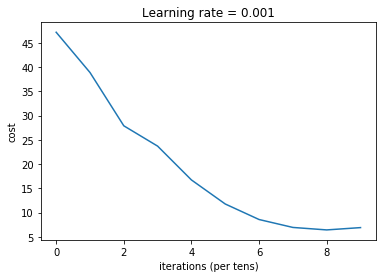

In [61]:
train_neural_network(X_train, y_train, X_test, y_test, epochs=10, batch_size=128)